This notebook is to investigate the issue of no buildings being built in some large areas starting in 2023 or so.

In [2]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
store = pd.HDFStore('./../runs/run29.h5')
parcels_lid = store['base/parcels'][['large_area_id']]

In [4]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: ./../runs/run29.h5
/2016/buildings                                             frame        (shape->[2397034,11])
/2016/dropped_buildings                                     frame        (shape->[8362,12])   
/2016/feasibility                                           frame                             
/2016/households                                            frame        (shape->[1875551,8]) 
/2016/jobs                                                  frame        (shape->[1,4])       
/2016/parcels                                               frame        (shape->[1794449,15])
/2016/persons                                               frame        (shape->[4653065,7]) 
/2017/buildings                                             frame        (shape->[2398758,11])
/2017/dropped_buildings                                     frame        (shape->[9364,12])   
/2017/feasibility                                           frame            

In [8]:
run29_buildings = pd.read_csv('run29_total.csv', index_col=0)

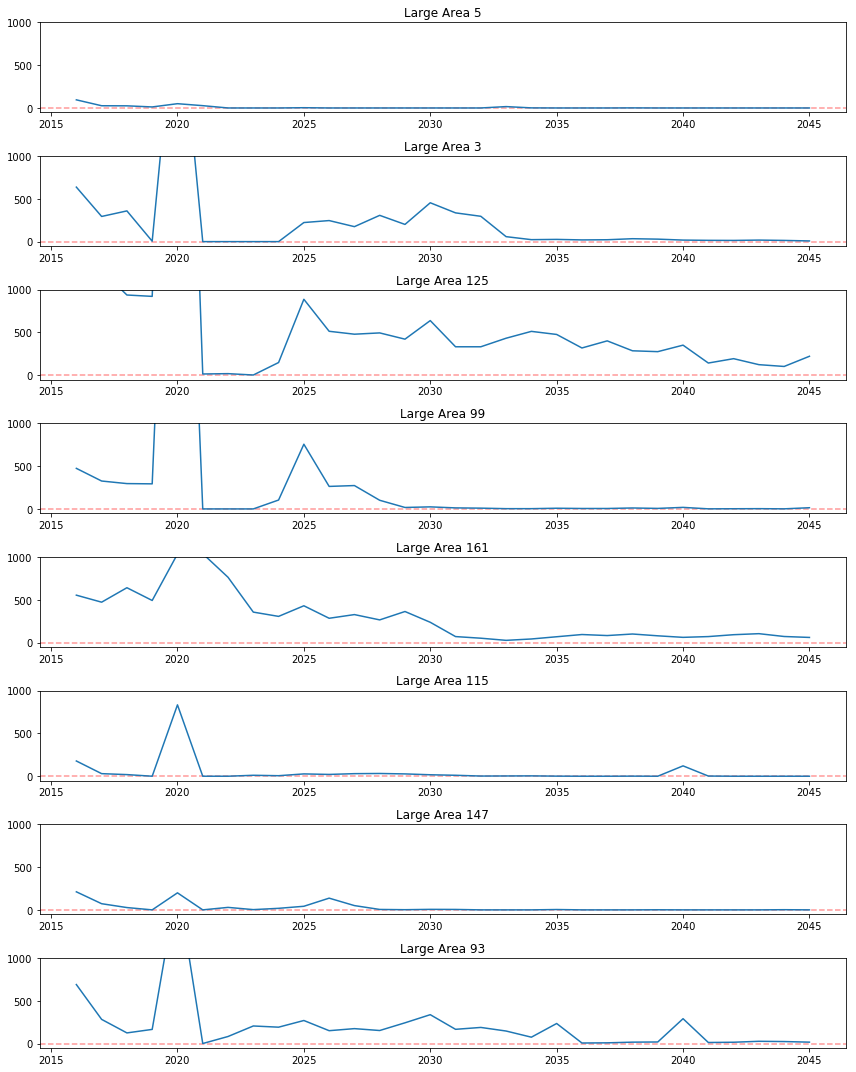

In [115]:
figure, axes_list = plt.subplots(len(run29_buildings), 1, figsize=(12, 15))
for i, ax in enumerate(axes_list):
    row = run29_buildings.fillna(0).iloc[i]
    ax.set_title('Large Area {}'.format(row.name))
    ax.axhline(y=0, color='red', alpha=0.4, linestyle='dashed')
    ax.set_ylim(bottom=-50, top=1000)
    ax.plot(row.index, row.values)
    
#     res_prices = res.fillna(0).iloc[i]
#     nonres_prices = nonres.fillna(0).iloc[i]
#     ax.plot(res_prices.index, res_prices.values, color='green', alpha=0.6, linestyle='dotted')
#     ax.plot(nonres_prices.index, nonres_prices.values, color='orange', alpha=0.6, linestyle='dotted')
    
figure.tight_layout()

In [85]:
# CHECK LENGTH OF FEASIBILITY TABLE
# This would tell us whether zoning is preventing development

# Residential

feas = pd.DataFrame(index=parcels_lid.large_area_id.unique())
for year in range(2016, 2046):
    feasibility_name = '{}/feasibility'.format(year)
    feasibility = store[feasibility_name]['residential']
    feasibility = feasibility[feasibility.max_profit_far > 0]
    f = feasibility.merge(parcels_lid, left_index=True, right_index=True)
    bylid = f.groupby('large_area_id').size()
    feas[year] = bylid

In [86]:
feas[2035]

5         12
3       2212
125    16207
99       219
161     1197
115      128
147       27
93      1318
Name: 2035, dtype: int64

In [60]:
df = store['2037/feasibility']['residential']
df = df.merge(parcels_lid, left_index=True, right_index=True)
df = df.loc[df.large_area_id == 3]
df = df.loc[df.max_profit_far > 0]

In [65]:
b = store['2037/buildings']
b = b.merge(parcels_lid, left_on='parcel_id', right_index=True)
b = b.loc[b.large_area_id == 3]

In [72]:
df['current_units'] = b.groupby('parcel_id').sum()['residential_units']
df.current_units = df.current_units.fillna(0)

In [79]:
df['net_units'] = (df.residential_sqft / 2000).round() - df.current_units

In [80]:
df.net_units.sum()

434.0

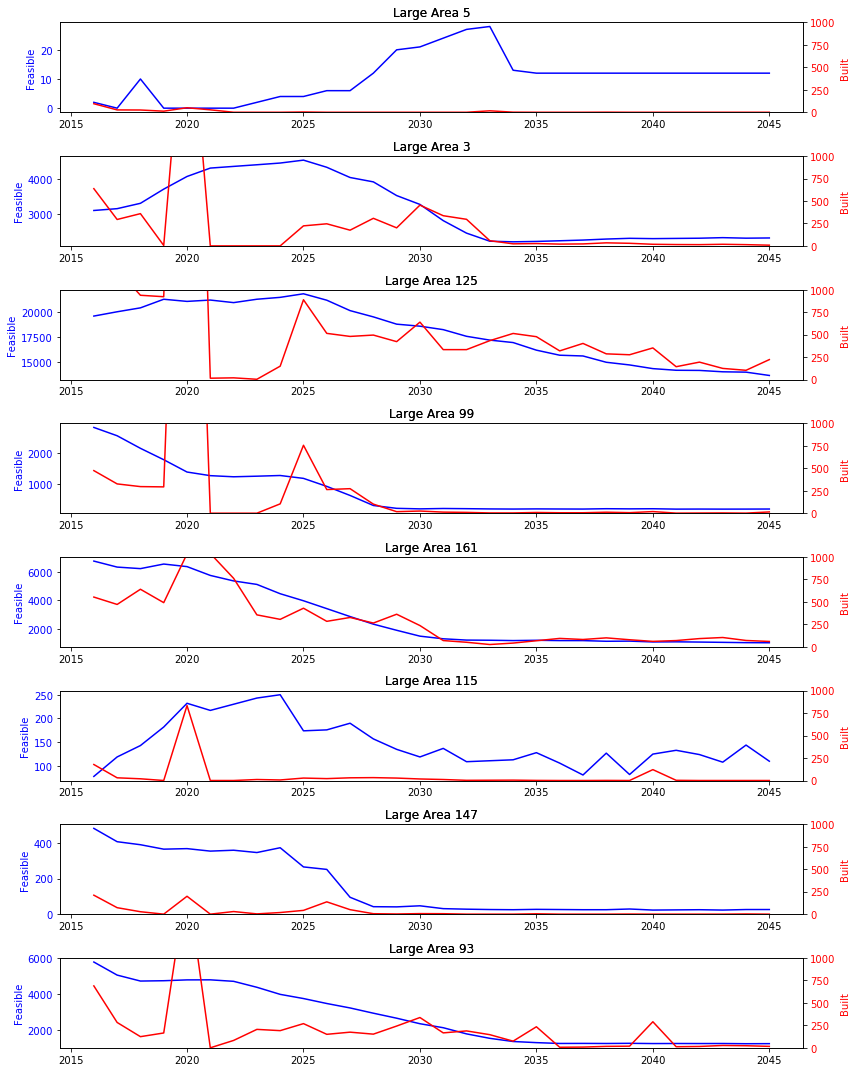

In [29]:
figure, axes_list = plt.subplots(len(feas), 1, figsize=(12, 15))
for i, ax in enumerate(axes_list):
    row = feas.fillna(0).iloc[i]
    ax.set_title('Large Area {}'.format(row.name))
    ax.plot(row.index, row.values, color='blue')
#     ax.set_ylim(top=5000, bottom=0)
    ax.set_ylabel('Feasible', color='blue')
    
    ax2 = ax.twinx()
    build = run29_buildings.fillna(0).iloc[i]
    ax2.set_title('Large Area {}'.format(row.name))
    ax2.plot(build.index, build.values, color='red')
    ax2.set_ylim(top=1000, bottom=0)
    ax2.set_ylabel('Built', color='red')
    
    for t in ax.get_yticklabels():
        t.set_color('blue')
        
    for t in ax2.get_yticklabels():
        t.set_color('red')
        
figure.tight_layout()

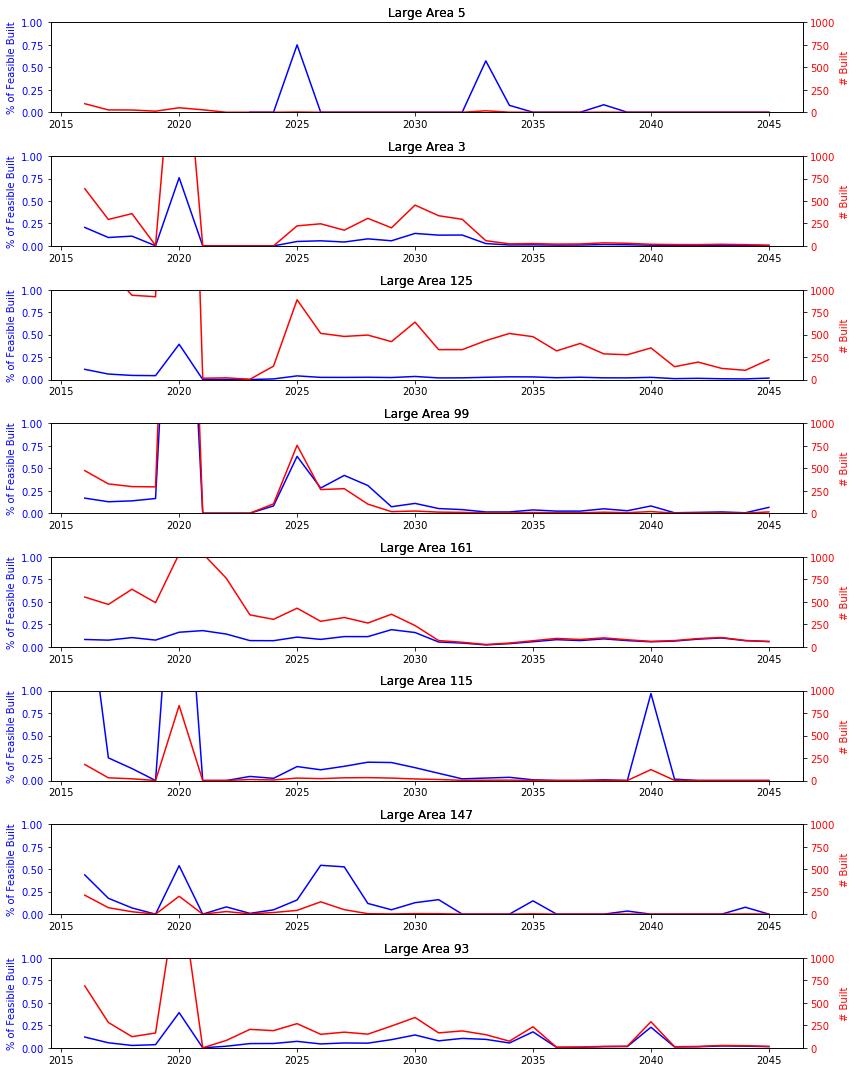

In [48]:
figure, axes_list = plt.subplots(len(feas), 1, figsize=(12, 15))
for i, ax in enumerate(axes_list):
    row = feas.fillna(0).iloc[i]
    ax.set_title('Large Area {}'.format(row.name))
#     ax.plot(row.index, row.values, color='blue')
    ax.set_ylim(top=1.0, bottom=0)
    ax.set_ylabel('% of Feasible Built', color='blue')
    
    ax2 = ax.twinx()
    build = run29_buildings.fillna(0).iloc[i]
    build.index = build.index.astype(int)
    ax2.set_title('Large Area {}'.format(row.name))
    ax2.plot(build.index, build.values, color='red')
    ax2.set_ylim(top=1000, bottom=0)
    ax2.set_ylabel('# Built', color='red')
    
    props = build/row
    ax.plot(props.index, props.values, color='blue')
    
    for t in ax.get_yticklabels():
        t.set_color('blue')
        
    for t in ax2.get_yticklabels():
        t.set_color('red')
        
figure.tight_layout()

### Parcel Allowed

In [100]:
buildings

,residential_units,year_built,parcel_id,land_area,improvement_value,stories,building_type_id,non_residential_sqft,sqft_price_res,sqft_per_unit,sqft_price_nonres
building_id,,,,,,,,,,,
1129903,1.0,1976,1329075,3008,183791.183432,1.00,81,0.0000,250.336043,1689,0.000000
1130036,1.0,0,1330161,1483,275147.232895,2.00,81,0.0000,0.559395,2966,0.000000
1130235,1.0,1990,1327233,1748,200795.690550,1.00,81,0.0000,183.941754,1925,0.000000
1130238,1.0,2003,1330438,3444,462850.241031,1.00,81,0.0000,214.884391,3567,0.000000
1130302,1.0,1986,1328382,1948,194428.131110,1.00,81,0.0000,262.257657,1738,0.000000
1130304,1.0,1986,1328427,2090,180083.366187,1.00,81,0.0000,292.117233,1318,0.000000
1130305,1.0,2003,1330520,2798,478095.203549,1.25,81,0.0000,202.620534,3831,0.000000
1130388,1.0,1987,1328457,1689,201247.884187,1.00,81,0.0000,232.319318,1795,0.000000
1130404,1.0,2003,1330437,2877,496839.212465,1.00,81,0.0000,209.758869,3529,0.000000


In [103]:
form_to_btype = {
    'residential': [81, 82, 83],
    'industrial': [31, 32],
    'retail': [21, 22, 25, 26, 62],
    'office': [23, 24],
    'medical': [51, 52, 53],
    'mixedresidential': [21, 22, 81, 83],
    'mixedoffice': [21, 22, 81, 83],
}

def parcel_is_allowed(form, parcels, form_to_btype, buildings, zoning, year,
                      events_addition, events_deletion, refinements):
    index = parcels.index
    buildings = buildings[["parcel_id", "building_type_id", "residential_units", "year_built"]]

    
    year_built = buildings.year_built
    year_built[year_built < 1600] = year_built[year_built > 1600].mean()
    age = year - year_built
    buildings['building_age'] = age

    new_building = buildings.groupby("parcel_id").building_age.min() <= 5
    new_building = new_building.reindex(index, fill_value=False)

    development = index.isin(events_addition.parcel_id)

    demolition = index.isin(
        buildings[
            buildings.index.isin(events_deletion.building_id)
        ].parcel_id
    )

    parcel_refin = set()

    for e in refinements.location_expression:
        s = set(buildings.query(e).parcel_id)
        if len(s) < 20:
            parcel_refin |= s

    refiner = index.isin(parcel_refin)

    protected = new_building | development | demolition | refiner

    columns = ['type%d' % typ for typ in form_to_btype[form]]
    allowed = zoning[columns].max(axis=1).reindex(index, fill_value=0)

    return (allowed > 0) & (~protected)

In [96]:
base_parcels = store['base/parcels']
zoning = store['base/zoning']
events_addition = store['base/events_addition']
events_deletion = store['base/events_deletion']
refinements = store['base/refiner_events']

In [104]:
allowed = pd.DataFrame(index=base_parcels.index)
for year in range(2016, 2046):
    parcels = store['{}/parcels'.format(year)]
    buildings = store['{}/buildings'.format(year)]
    a = parcel_is_allowed('residential', parcels, form_to_btype,
                          buildings, zoning, year, events_addition,
                          events_deletion, refinements)
    allowed[year] = a
    

/home/pksohn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pksohn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pksohn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [106]:
allowed.to_csv('run29_parcels_allowed.csv')

In [108]:
allowed = allowed.merge(parcels_lid, left_index=True, right_index=True)

In [112]:
allowed.groupby('large_area_id').mean()

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,...,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045
large_area_id,,,,,,,,,,,,,,,,,,,,,
3,0.902444,0.903135,0.904383,0.905804,0.906883,0.907611,0.907611,0.907788,0.907788,0.907382,...,0.905922,0.906694,0.907338,0.90741,0.907422,0.907449,0.907464,0.907473,0.907523,0.907574
5,0.90479,0.904822,0.90483,0.904879,0.904914,0.905163,0.905163,0.905179,0.905187,0.905187,...,0.905141,0.905141,0.905138,0.905182,0.905184,0.905184,0.905184,0.905184,0.905187,0.905187
93,0.730834,0.73139,0.732889,0.736936,0.741926,0.746206,0.745701,0.744189,0.743206,0.743529,...,0.743607,0.74565,0.74786,0.749515,0.750278,0.750575,0.750446,0.750265,0.7502,0.7502
99,0.899262,0.900168,0.901323,0.90253,0.903978,0.904669,0.904669,0.905374,0.90602,0.906217,...,0.907339,0.907365,0.907357,0.907346,0.907316,0.907339,0.90735,0.907357,0.907394,0.907413
115,0.631899,0.632969,0.634259,0.636667,0.639264,0.6426,0.6426,0.642568,0.64271,0.642285,...,0.642647,0.64282,0.642836,0.642883,0.64293,0.642914,0.642914,0.642914,0.64293,0.64293
125,0.888387,0.88863,0.889892,0.891739,0.894389,0.897062,0.897839,0.899629,0.900722,0.901153,...,0.897622,0.897509,0.897679,0.898086,0.898948,0.899426,0.899752,0.900418,0.90079,0.900899
147,0.575588,0.575759,0.575956,0.576548,0.577233,0.579523,0.579141,0.57926,0.579233,0.57876,...,0.579813,0.579878,0.579878,0.579865,0.579865,0.579878,0.579878,0.579878,0.579852,0.579865
161,0.751912,0.751341,0.753241,0.754889,0.755647,0.757173,0.757117,0.756237,0.754178,0.752352,...,0.764971,0.764943,0.764541,0.764147,0.76397,0.764016,0.764026,0.763792,0.764073,0.764204


### Comparing table from within developer model to feasibility output

In [10]:
dev = pd.read_csv('./res_dev_table_lid3.csv', index_col=0)

In [19]:
dev.sort_index().head()

,parking_config,building_cost,building_revenue,building_sqft,construction_time,financing_cost,max_profit,max_profit_far,parking_ratio,stories,total_cost,residential_sqft,non_residential_sqft,ave_unit_size,parcel_size,current_units,residential_units,job_spaces,net_units
parcel_id,,,,,,,,,,,,,,,,,,,
1011934,surface,443620.800,463703.489319,3888.00,12.0,15526.728000,4555.961319,0.25,0.0,1.0,459147.528000,3304.8000,0.0,1814.268311,15552,0.0,2.0,0.0,2.0
1012048,surface,216162.450,225948.112272,1894.50,12.0,7565.685750,2219.976522,0.25,0.0,1.0,223728.135750,1610.3250,0.0,1814.268311,7578,0.0,1.0,0.0,1.0
1014617,surface,240408.700,266400.314551,2107.00,12.0,8414.304500,17577.310051,0.25,0.0,1.0,248823.004500,1790.9500,0.0,2574.521729,8428,0.0,1.0,0.0,1.0
1018726,surface,296545.900,307744.242503,2599.00,12.0,10379.106500,819.236003,0.25,0.0,1.0,306925.006500,2209.1500,0.0,2208.625000,10396,0.0,1.0,0.0,1.0
1019426,surface,557292.925,579526.994495,4884.25,12.0,19505.252375,2728.817120,0.25,0.0,1.0,576798.177375,4151.6125,0.0,2189.954590,19537,1.0,2.0,0.0,1.0


In [37]:
len(dev)

679

In [35]:
sum([(i in feas.index) for i in dev.index])

263

In [34]:
feas = store29['2035/feasibility']['residential']
feas = feas.merge(parcels_lid, left_index=True, right_index=True)
feas = feas.loc[feas.large_area_id == 3]

In [40]:
sum([(i in parcels_lid.loc[parcels_lid.large_area_id == 3].index) for i in dev.index])

679

In [36]:
len(feas)

202176

In [18]:
feas = feas.dropna(subset=['max_profit'])
feas.sort_index()

,non_residential_sqft,parking_config,financing_cost,building_sqft,stories,total_cost,max_profit,building_cost,max_profit_far,construction_time,building_revenue,parking_ratio,residential_sqft,large_area_id
parcel_id,,,,,,,,,,,,,,
1007005,0.0,surface,2016.717500,505.00,1.0,59637.217500,3264.701277,57620.500,0.250,12.0,6.290192e+04,0.0,429.2500,3
1007446,0.0,surface,2760.506875,691.25,1.0,81632.131875,151560.662198,78871.625,0.250,12.0,2.331928e+05,0.0,587.5625,3
1007451,0.0,surface,2224.379500,557.00,1.0,65778.079500,122125.553482,63553.700,0.250,12.0,1.879036e+05,0.0,473.4500,3
1007554,0.0,surface,8548.086750,2140.50,1.0,252779.136750,35003.198880,244231.050,0.250,12.0,2.877823e+05,0.0,1819.4250,3
1007584,0.0,surface,23965.133938,3292.75,1.0,708683.246463,9658.709300,375702.775,0.250,12.0,7.183420e+05,0.0,2798.8375,3
1007600,0.0,surface,24540.253209,3427.25,1.0,725690.344909,27121.501829,391049.225,0.250,12.0,7.528118e+05,0.0,2913.1625,3
1007658,0.0,surface,33173.585923,2952.50,1.0,980990.326585,29037.005679,336880.250,0.250,12.0,1.010027e+06,0.0,2509.6250,3
1007660,0.0,surface,29184.058148,2688.50,1.0,863014.290961,22632.022284,306757.850,0.250,12.0,8.856463e+05,0.0,2285.2250,3
1008296,0.0,surface,30438.574038,3051.65,1.0,900112.117968,3474.387856,348193.265,0.175,12.0,9.035865e+05,0.0,2593.9025,3
